### Demonstration of `flopy.utils.get_transmissivities` method
for computing open interval transmissivities (for weighted averages of heads or fluxes)
In practice this method might be used to:  

* compute vertically-averaged head target values representative of observation wells of varying open intervals (including variability in saturated thickness due to the position of the water table)
* apportion boundary fluxes (e.g. from an analytic element model) among model layers based on transmissivity.
* any other analysis where a distribution of transmissivity by layer is needed for a specified vertical interval of the model.

In [1]:
import os
import sys
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]
numpy version: 1.24.1
matplotlib version: 3.6.3
flopy version: 3.3.7


### Make up some open interval tops and bottoms and some heads
* (these could be lists of observation well screen tops and bottoms)
* the heads array contains the simulated head in each model layer,
  at the location of each observation well (for example, what you would get back from HYDMOD if you had an entry for each layer at the location of each head target).
* make up a model grid with uniform horizontal k of 2.

In [2]:
sctop = [-0.25, 0.5, 1.7, 1.5, 3.0, 2.5]  # screen tops
scbot = [-1.0, -0.5, 1.2, 0.5, 1.5, -0.2]  # screen bottoms
# head in each layer, for 6 head target locations
heads = np.array(
    [
        [1.0, 2.0, 2.05, 3.0, 4.0, 2.5],
        [1.1, 2.1, 2.2, 2.0, 3.5, 3.0],
        [1.2, 2.3, 2.4, 0.6, 3.4, 3.2],
    ]
)
nl, nr = heads.shape
nc = nr
botm = np.ones((nl, nr, nc), dtype=float)
top = np.ones((nr, nc), dtype=float) * 2.1
hk = np.ones((nl, nr, nc), dtype=float) * 2.0
for i in range(nl):
    botm[nl - i - 1, :, :] = i
botm

array([[[2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2.]],

       [[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]])

### Make a flopy modflow model

In [3]:
# temporary directory
temp_dir = TemporaryDirectory()
model_ws = temp_dir.name

m = flopy.modflow.Modflow("junk", version="mfnwt", model_ws=model_ws)
dis = flopy.modflow.ModflowDis(
    m, nlay=nl, nrow=nr, ncol=nc, botm=botm, top=top
)
upw = flopy.modflow.ModflowUpw(m, hk=hk)

### Get transmissivities along the diagonal cells
* alternatively, if a model's coordinate information has been set up, the real-world x and y coordinates could be supplied with the `x` and `y` arguments
* if `sctop` and `scbot` arguments are given, the transmissivites are computed for the open intervals only
  (cells that are partially within the open interval have reduced thickness, cells outside of the open interval have transmissivities of 0). If no `sctop` or `scbot` arguments are supplied, trasmissivites reflect the full saturated thickness in each column of cells (see plot below, which shows different open intervals relative to the model layering)

In [4]:
r, c = np.arange(nr), np.arange(nc)
T = flopy.utils.get_transmissivities(
    heads, m, r=r, c=c, sctop=sctop, scbot=scbot
)
np.round(T, 2)

array([[0. , 0. , 0. , 0. , 0.2, 0.2],
       [0. , 0. , 1. , 1. , 1. , 2. ],
       [2. , 1. , 0. , 0.2, 0. , 2. ]])

In [5]:
m.dis.botm.array[:, r, c]

array([[2., 2., 2., 2., 2., 2.],
       [1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

### Plot the model top and layer bottoms (colors)
open intervals are shown as boxes
* well 0 has zero transmissivities for each layer, as it is below the model bottom
* well 1 has T values of 0 for layers 1 and 2, and 1 for layer 3 (K=2 x 0.5 thickness)

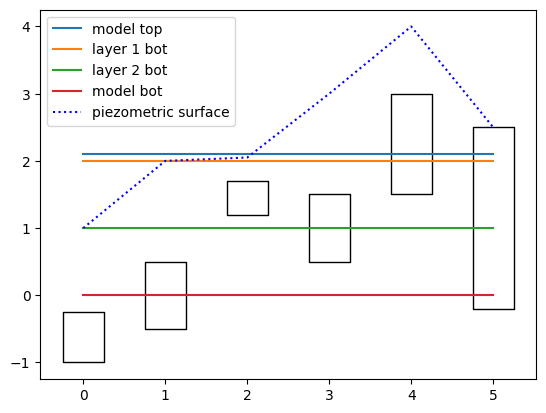

In [6]:
fig, ax = plt.subplots()
plt.plot(m.dis.top.array[r, c], label="model top")
for i, l in enumerate(m.dis.botm.array[:, r, c]):
    label = "layer {} bot".format(i + 1)
    if i == m.nlay - 1:
        label = "model bot"
    plt.plot(l, label=label)
plt.plot(heads[0], label="piezometric surface", color="b", linestyle=":")
for iw in range(len(sctop)):
    ax.fill_between(
        [iw - 0.25, iw + 0.25],
        scbot[iw],
        sctop[iw],
        facecolor="None",
        edgecolor="k",
    )
ax.legend(loc=2)

### example of transmissivites without `sctop` and `scbot`
* well zero has T=0 in layer 1 because it is dry; T=0.2 in layer 2 because the sat. thickness there is only 0.1

In [7]:
T = flopy.utils.get_transmissivities(heads, m, r=r, c=c)
np.round(T, 2)

array([[0. , 0. , 0.1, 0.2, 0.2, 0.2],
       [0.2, 2. , 2. , 2. , 2. , 2. ],
       [2. , 2. , 2. , 1.2, 2. , 2. ]])

In [8]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass